<a href="https://colab.research.google.com/github/RaihanAzharRafi/Machine-Learning/blob/main/WEEK%2014/Week_14_Modern_RNN_machine_translation_and_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Translation and the Dataset**
### **Nama : Raihan Azhar Rafi**
### **Kelas : TK-42-02**
### **Nim : 1103180166**

Sumber Saya Peroleh Dari : http://www.d2l.ai/chapter_recurrent-modern/machine-translation-and-dataset.html

In [1]:
!pip install d2l==0.17.5


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Machine Translation and the Dataset
:label:`sec_machine_translation`

We have used RNNs to design language models,
which are key to natural language processing.
Another flagship benchmark is *machine translation*,
a central problem domain for *sequence transduction* models
that transform input sequences into output sequences.
Playing a crucial role in various modern AI applications,
sequence transduction models will form the focus of the remainder of this chapter
and :numref:`chap_attention`.
To this end,
this section introduces the machine translation problem
and its dataset that will be used later.


*Machine translation* refers to the
automatic translation of a sequence
from one language to another.
In fact, this field
may date back to 1940s
soon after digital computers were invented,
especially by considering the use of computers
for cracking language codes in World War II.
For decades,
statistical approaches
had been dominant in this field :cite:`Brown.Cocke.Della-Pietra.ea.1988,Brown.Cocke.Della-Pietra.ea.1990`
before the rise
of
end-to-end learning using
neural networks.
The latter
is often called
*neural machine translation*
to distinguish itself from
*statistical machine translation*
that involves statistical analysis
in components such as
the translation model and the language model.


Emphasizing end-to-end learning,
this book will focus on neural machine translation methods.
Different from our language model problem
in :numref:`sec_language_model`
whose corpus is in one single language,
machine translation datasets
are composed of pairs of text sequences
that are in
the source language and the target language, respectively.
Thus,
instead of reusing the preprocessing routine
for language modeling,
we need a different way to preprocess
machine translation datasets.
In the following,
we show how to
load the preprocessed data
into minibatches for training.


In [2]:
import os
import tensorflow as tf
from d2l import tensorflow as d2l

## [**Downloading and Preprocessing the Dataset**]

To begin with,
we download an English-French dataset
that consists of [bilingual sentence pairs from the Tatoeba Project](http://www.manythings.org/anki/).
Each line in the dataset
is a tab-delimited pair
of an English text sequence
and the translated French text sequence.
Note that each text sequence
can be just one sentence or a paragraph of multiple sentences.
In this machine translation problem
where English is translated into French,
English is the *source language*
and French is the *target language*.


In [3]:
#@save
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip',
                           '94646ad1522d915e7b0f9296181140edcf86a4f5')

#@save
def read_data_nmt():
    """Load the English-French dataset."""
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r') as f:
        return f.read()

raw_text = read_data_nmt()
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



After downloading the dataset,
we [**proceed with several preprocessing steps**]
for the raw text data.
For instance,
we replace non-breaking space with space,
convert uppercase letters to lowercase ones,
and insert space between words and punctuation marks.


In [4]:
#@save
def preprocess_nmt(text):
    """Preprocess the English-French dataset."""
    def no_space(char, prev_char):
        return char in set(',.!?') and prev_char != ' '

    # Replace non-breaking space with space, and convert uppercase letters to
    # lowercase ones
    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    # Insert space between words and punctuation marks
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

text = preprocess_nmt(raw_text)
print(text[:80])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça alors !


## [**Tokenization**]

Different from character-level tokenization
in :numref:`sec_language_model`,
for machine translation
we prefer word-level tokenization here
(state-of-the-art models may use more advanced tokenization techniques).
The following `tokenize_nmt` function
tokenizes the the first `num_examples` text sequence pairs,
where
each token is either a word or a punctuation mark.
This function returns
two lists of token lists: `source` and `target`.
Specifically,
`source[i]` is a list of tokens from the
$i^\mathrm{th}$ text sequence in the source language (English here) and `target[i]` is that in the target language (French here).


In [5]:
#@save
def tokenize_nmt(text, num_examples=None):
    """Tokenize the English-French dataset."""
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

source, target = tokenize_nmt(text)
source[:6], target[:6]

([['go', '.'],
  ['hi', '.'],
  ['run', '!'],
  ['run', '!'],
  ['who', '?'],
  ['wow', '!']],
 [['va', '!'],
  ['salut', '!'],
  ['cours', '!'],
  ['courez', '!'],
  ['qui', '?'],
  ['ça', 'alors', '!']])

Let us [**plot the histogram of the number of tokens per text sequence.**]
In this simple English-French dataset,
most of the text sequences have fewer than 20 tokens.


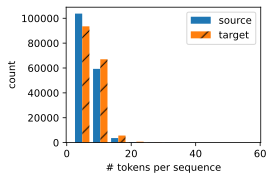

In [6]:
#@save
def show_list_len_pair_hist(legend, xlabel, ylabel, xlist, ylist):
    """Plot the histogram for list length pairs."""
    d2l.set_figsize()
    _, _, patches = d2l.plt.hist(
        [[len(l) for l in xlist], [len(l) for l in ylist]])
    d2l.plt.xlabel(xlabel)
    d2l.plt.ylabel(ylabel)
    for patch in patches[1].patches:
        patch.set_hatch('/')
    d2l.plt.legend(legend)

show_list_len_pair_hist(['source', 'target'], '# tokens per sequence',
                        'count', source, target);

## [**Vocabulary**]

Since the machine translation dataset
consists of pairs of languages,
we can build two vocabularies for
both the source language and
the target language separately.
With word-level tokenization,
the vocabulary size will be significantly larger
than that using character-level tokenization.
To alleviate this,
here we treat infrequent tokens
that appear less than 2 times
as the same unknown ("&lt;unk&gt;") token.
Besides that,
we specify additional special tokens
such as for padding ("&lt;pad&gt;") sequences to the same length in minibatches,
and for marking the beginning ("&lt;bos&gt;") or end ("&lt;eos&gt;") of sequences.
Such special tokens are commonly used in
natural language processing tasks.


In [7]:
src_vocab = d2l.Vocab(source, min_freq=2,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

10012

## Reading the Dataset
:label:`subsec_mt_data_loading`

Recall that in language modeling
[**each sequence example**],
either a segment of one sentence
or a span over multiple sentences,
(**has a fixed length.**)
This was specified by the `num_steps`
(number of time steps or tokens) argument in :numref:`sec_language_model`.
In machine translation, each example is
a pair of source and target text sequences,
where each text sequence may have different lengths.

For computational efficiency,
we can still process a minibatch of text sequences
at one time by *truncation* and *padding*.
Suppose that every sequence in the same minibatch
should have the same length `num_steps`.
If a text sequence has fewer than `num_steps` tokens,
we will keep appending the special "&lt;pad&gt;" token
to its end until its length reaches `num_steps`.
Otherwise,
we will truncate the text sequence
by only taking its first `num_steps` tokens
and discarding the remaining.
In this way,
every text sequence
will have the same length
to be loaded in minibatches of the same shape.

The following `truncate_pad` function
(**truncates or pads text sequences**) as described before.


In [8]:
#@save
def truncate_pad(line, num_steps, padding_token):
    """Truncate or pad sequences."""
    if len(line) > num_steps:
        return line[:num_steps]  # Truncate
    return line + [padding_token] * (num_steps - len(line))  # Pad

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

Now we define a function to [**transform
text sequences into minibatches for training.**]
We append the special “&lt;eos&gt;” token
to the end of every sequence to indicate the
end of the sequence.
When a model is predicting
by
generating a sequence token after token,
the generation
of the “&lt;eos&gt;” token
can suggest that
the output sequence is complete.
Besides,
we also record the length
of each text sequence excluding the padding tokens.
This information will be needed by
some models that
we will cover later.


In [9]:
#@save
def build_array_nmt(lines, vocab, num_steps):
    """Transform text sequences of machine translation into minibatches."""
    lines = [vocab[l] for l in lines]
    lines = [l + [vocab['<eos>']] for l in lines]
    array = tf.constant([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = tf.reduce_sum(
        tf.cast(array != vocab['<pad>'], tf.int32), 1)
    return array, valid_len

## [**Putting All Things Together**]

Finally, we define the `load_data_nmt` function
to return the data iterator, together with
the vocabularies for both the source language and the target language.


In [10]:
#@save
def load_data_nmt(batch_size, num_steps, num_examples=600):
    """Return the iterator and the vocabularies of the translation dataset."""
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=2,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array_nmt(source, src_vocab, num_steps)
    tgt_array, tgt_valid_len = build_array_nmt(target, tgt_vocab, num_steps)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return data_iter, src_vocab, tgt_vocab

Let us [**read the first minibatch from the English-French dataset.**]


In [11]:
train_iter, src_vocab, tgt_vocab = load_data_nmt(batch_size=2, num_steps=8)
for X, X_valid_len, Y, Y_valid_len in train_iter:
    print('X:', tf.cast(X, tf.int32))
    print('valid lengths for X:', X_valid_len)
    print('Y:', tf.cast(Y, tf.int32))
    print('valid lengths for Y:', Y_valid_len)
    break

X: tf.Tensor(
[[111  23   4   3   1   1   1   1]
 [118  55   4   3   1   1   1   1]], shape=(2, 8), dtype=int32)
valid lengths for X: tf.Tensor([4 4], shape=(2,), dtype=int32)
Y: tf.Tensor(
[[0 5 3 1 1 1 1 1]
 [0 4 3 1 1 1 1 1]], shape=(2, 8), dtype=int32)
valid lengths for Y: tf.Tensor([3 3], shape=(2,), dtype=int32)
